#### If yfinance is not already installed, uncomment the code block below, and run

In [ ]:
#!pip install yfinance


In [1]:

import yfinance as yf  
import pandas as pd
import matplotlib.pyplot as plt
from numpy import *
from datetime import datetime
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
now = datetime.now()
now = str(now.year)+"-"+str(now.month)+"-"+str(now.day)
import requests
import pandas as pd
import arrow
import datetime
import os


### MACD
https://school.stockcharts.com/doku.php?id=technical_indicators:moving_average_convergence_divergence_macd


As its name implies, the MACD is all about the convergence and divergence of the two moving averages. Convergence occurs when the moving averages move towards each other. Divergence occurs when the moving averages move away from each other. The shorter moving average (12-day) is faster and responsible for most MACD movements. The longer moving average (26-day) is slower and less reactive to price changes in the underlying security.

The MACD line oscillates above and below the zero line, which is also known as the centerline. These crossovers signal that the 12-day EMA has crossed the 26-day EMA. The direction, of course, depends on the direction of the moving average cross. Positive MACD indicates that the 12-day EMA is above the 26-day EMA. Positive values increase as the shorter EMA diverges further from the longer EMA. This means upside momentum is increasing. Negative MACD values indicate that the 12-day EMA is below the 26-day EMA. Negative values increase as the shorter EMA diverges further below the longer EMA. This means downside momentum is increasing.

### Signal Line

Signal Line Crossovers
Signal line crossovers are the most common MACD signals. The signal line is a 9-day EMA of the MACD line. As a moving average of the indicator, it trails the MACD and makes it easier to spot MACD turns. A bullish crossover occurs when the MACD turns up and crosses above the signal line. A bearish crossover occurs when the MACD turns down and crosses below the signal line. Crossovers can last a few days or a few weeks, depending on the strength of the move.

Due diligence is required before relying on these common signals. Signal line crossovers at positive or negative extremes should be viewed with caution. Even though the MACD does not have upper and lower limits, chartists can estimate historical extremes with a simple visual assessment. It takes a strong move in the underlying security to push momentum to an extreme. Even though the move may continue, momentum is likely to slow and this will usually produce a signal line crossover at the extremities. Volatility in the underlying security can also increase the number of crossovers.

In [2]:


def get_quote_data_by_minute(symbol='SPCE', data_range='1d', data_interval='1m'):
    res = requests.get('https://query1.finance.yahoo.com/v8/finance/chart/{symbol}?range={data_range}&interval={data_interval}'.format(**locals()),verify=True)
    data = res.json()
    body = data['chart']['result'][0]    
    dt = datetime.datetime
    dt = pd.Series(map(lambda x: arrow.get(x).datetime.replace(tzinfo=None), body['timestamp']), name='Datetime')
    df = pd.DataFrame(body['indicators']['quote'][0], index=dt)
    dg = pd.DataFrame(body['timestamp'])    
    df = df.loc[:, ('open', 'high', 'low', 'close', 'volume')]
    df.dropna(inplace=True)     #removing NaN rows
    df.columns = ['OPEN', 'HIGH','LOW','CLOSE','VOLUME']    #Renaming columns in pandas
    df=df.reset_index()
    return df

In [81]:
def generate_stock_data(start_date,end_date,ticker):
    data = yf.download(ticker,start_date,end_date)
    
    data=data.reset_index()
    data=data.sort_values('Date')
    data=data[['Date','Open','Close','Volume','High','Low']]
    
    
    data['ticker']=ticker
    min_by_min.loc[min_by_min.shape[0]-1]
    #extract day of the week
    mapping = {0:'Mon',1:'Tues',2:'Wed',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
    data['DOW'] = data['Date'].dt.dayofweek
    data['DOW_Mapped'] =data['DOW'].map(mapping)
    
    
    #calculate 7 day moving average with open and close
    data['5Day_Moving_Average_Close'] = data['Close'].rolling(window=5).mean()
    data['5Day_Moving_Average_Open'] = data['Open'].rolling(window=5).mean()
    
    #long ma 
    data['26Day_Moving_Average_Close'] = data['Close'].ewm(span=26).mean()
    
    #mid ma 
    data['12Day_Moving_Average_Close'] = data['Close'].ewm(span=12).mean()
    
    
    #short ma
    data['9Day_Moving_Average_Close'] = data['Close'].ewm(span=9).mean()
    
    
    #MACD
    data['MACD']=data['12Day_Moving_Average_Close']-data['26Day_Moving_Average_Close']
    
    
    
    #average the MACD to derive the signal line
    data['signal'] = data['MACD'].ewm(span=9).mean()
    
    
    # difference the macd from the sinal line to find the acceleration histogram
    data['hist'] = data['MACD'] - data['signal']
    

    
    #lag variables 1 DAY
    data['Close_Shift_1']=    data['Close'].shift(1)
    data['Open_Shift_1']=    data['Open'].shift(1)
    
    #lag variables 1 WEEK
    data['Close_Shift_5']=    data['Close'].shift(5)
    data['Open_Shift_5']=    data['Open'].shift(5)
    
    
    #prev_day_hi_or_low close
    data['Prev_Day_Compare_Close'] = data['Close']-data['Close_Shift_1']
    data['Prev_Day_Growth_Close'] = (data['Close']-data['Close_Shift_1'])/data['Close_Shift_1']
    
    
    #prev_day_hi_or_low open
    data['Prev_Day_Compare_Open'] = data['Open']-data['Open_Shift_1']
    data['Prev_Day_Growth_Open'] = (data['Open']-data['Open_Shift_1'])/data['Open_Shift_1']
    
    
    
    
    #prev_day_hi_or_low close
    data['Prev_Week_Compare_Close'] = data['Close']-data['Close_Shift_5']
    data['Prev_Week_Growth_Close'] = (data['Close']-data['Close_Shift_5'])/data['Close_Shift_5']
    
    
    #prev_day_hi_or_low open
    data['Prev_Week_Compare_Open'] = data['Open']-data['Open_Shift_5']
    data['Prev_Week_Growth_Open'] = (data['Open']-data['Open_Shift_5'])/data['Open_Shift_5']
    
    
    
    
    data=data.iloc[5:]
    data

    
    return data




[*********************100%***********************]  1 of 1 completed


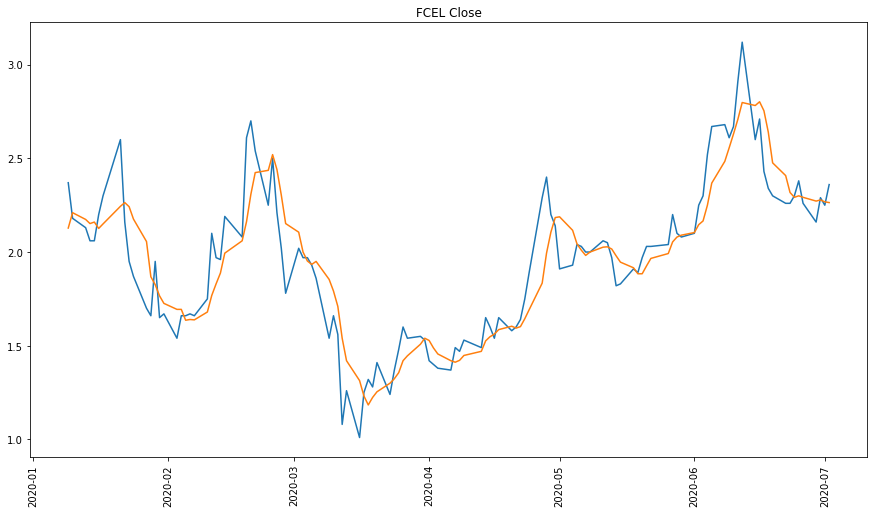

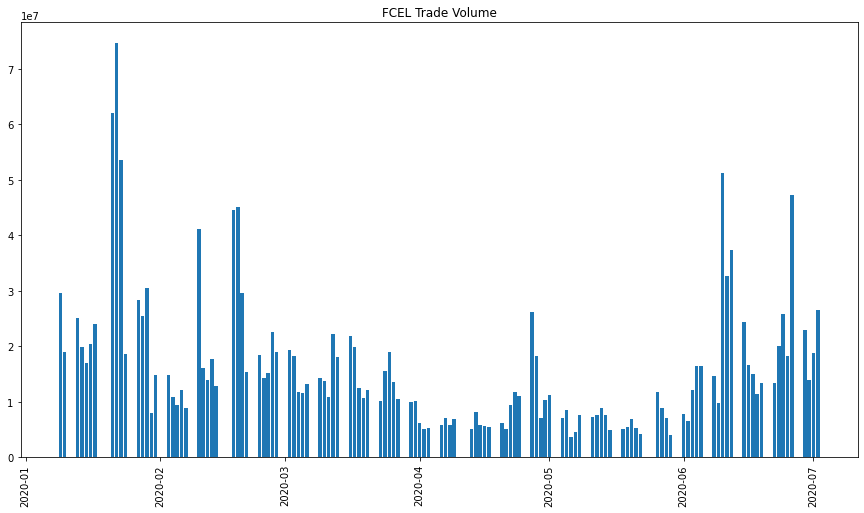

In [82]:
ticker='FCEL'
start = '2020-01-01'
SDOW = generate_stock_data(start,now,ticker)

plt.figure(figsize=(15,8))
plt.title('{} Close'.format(ticker))

plt.plot(SDOW['Date'],SDOW['Open'])

plt.plot(SDOW['Date'],SDOW['5Day_Moving_Average_Open'])

plt.xticks(rotation=90)
plt.show()
#----------------------------------------------

plt.figure(figsize=(15,8))
plt.title('{} Trade Volume'.format(ticker))


plt.bar(SDOW['Date'],SDOW['Volume'])

plt.xticks(rotation=90)
plt.show()


In [83]:
ticks = ['NVDA','DOCU','WDAY','PLUG','FCEL','QCOM','BUD','BAC','BOX','WKHS','UBER','SPWR','ABEV','DLPH','PTON']

In [84]:
SDOW.tail()

,Date,Open,Close,Volume,High,Low,ticker,DOW,DOW_Mapped,5Day_Moving_Average_Close,5Day_Moving_Average_Open,26Day_Moving_Average_Close,12Day_Moving_Average_Close,9Day_Moving_Average_Close,MACD,signal,hist,Close_Shift_1,Open_Shift_1,Close_Shift_5,Open_Shift_5,Prev_Day_Compare_Close,Prev_Day_Growth_Close,Prev_Day_Compare_Open,Prev_Day_Growth_Open,Prev_Week_Compare_Close,Prev_Week_Growth_Close,Prev_Week_Compare_Open,Prev_Week_Growth_Open
122,2020-06-26,2.26,2.09,47362700,2.31,2.03,FCEL,4,Fri,2.216,2.292,2.306248,2.313834,2.283786,0.007585,0.077143,-0.069558,2.22,2.38,2.20,2.30,-0.13,-0.058559,-0.12,-0.050420,-0.11,-0.050000,-0.04,-0.017391
123,2020-06-29,2.16,2.34,22897900,2.42,2.05,FCEL,0,Mon,2.250,2.272,2.308749,2.317859,2.295029,0.009110,0.063536,-0.054426,2.09,2.26,2.17,2.26,0.25,0.119617,-0.10,-0.044248,0.17,0.078341,-0.10,-0.044248
124,2020-06-30,2.29,2.26,13937300,2.33,2.16,FCEL,1,Tues,2.254,2.278,2.305137,2.308958,2.288023,0.003820,0.051593,-0.047773,2.34,2.16,2.24,2.26,-0.08,-0.034188,0.13,0.060185,0.02,0.008929,0.03,0.013274
125,2020-07-01,2.25,2.28,18828400,2.38,2.20,FCEL,2,Wed,2.238,2.268,2.303275,2.304503,2.286419,0.001227,0.041520,-0.040293,2.26,2.29,2.36,2.30,0.02,0.008850,-0.04,-0.017467,-0.08,-0.033898,-0.05,-0.021739
126,2020-07-02,2.36,2.52,26595300,2.58,2.30,FCEL,3,Thurs,2.298,2.264,2.319330,2.337656,2.333135,0.018326,0.036881,-0.018555,2.28,2.25,2.22,2.38,0.24,0.105263,0.11,0.048889,0.30,0.135135,-0.02,-0.008403


In [76]:
import datapackage

data_url = 'https://datahub.io/core/nasdaq-listings/datapackage.json'

# to load Data Package into storage
package = datapackage.Package(data_url)

# to load only tabular data
resources = package.resources
for resource in resources:
    if resource.tabular:
        NASDAQ = pd.read_csv(resource.descriptor['path'])
        

In [ ]:
all_data = []

for sym in NASDAQ['Symbol']:
    try:
        curr = generate_stock_data(start,now,sym)
        all_data.append(curr)
    except:
        print('{} is delisted'.format(sym))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AAVL: No data found for this date range, symbol may be delisted
AAVL is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ABAC: No data found for this date range, symbol may be delisted
ABAC is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ABAX: No data

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AFFX: No data found for this date range, symbol may be delisted
AFFX is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AFOP: No data found for this date range, symbol may be delisted
AFOP is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AFSI: No data found for this date range, symbol may be delisted
AFSI is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AGII: No data found for this date range, symbol may be delisted
AGII is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AGIIL: No data

[*********************100%***********************]  1 of 1 completed


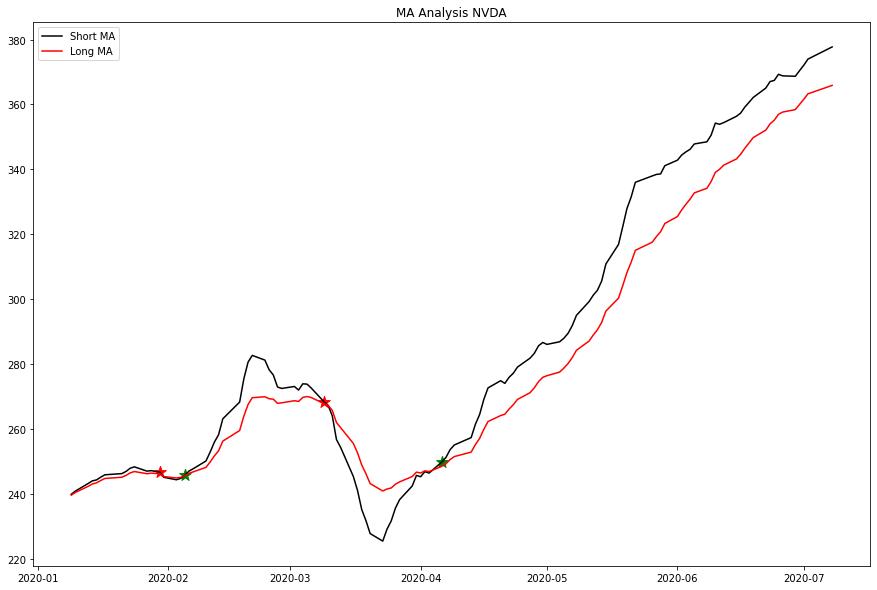

[*********************100%***********************]  1 of 1 completed


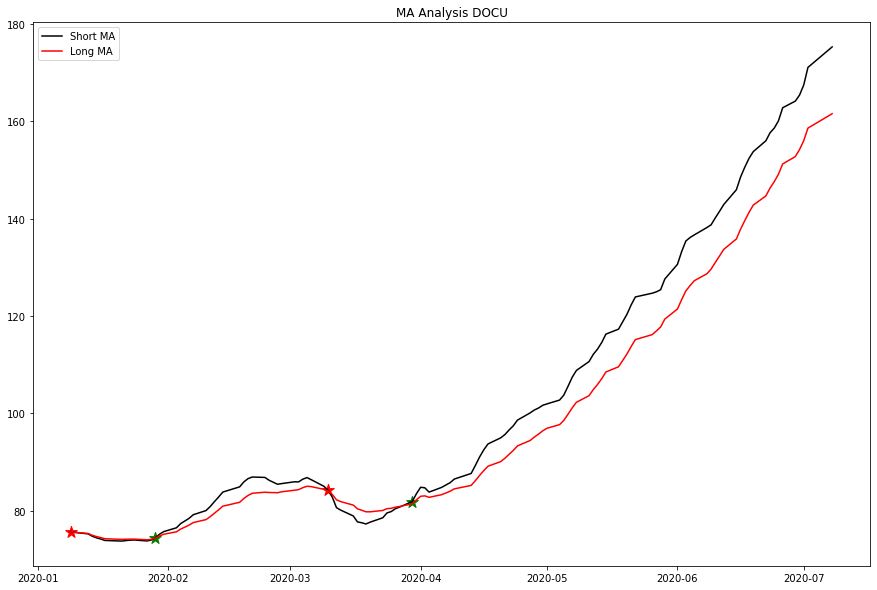

[*********************100%***********************]  1 of 1 completed


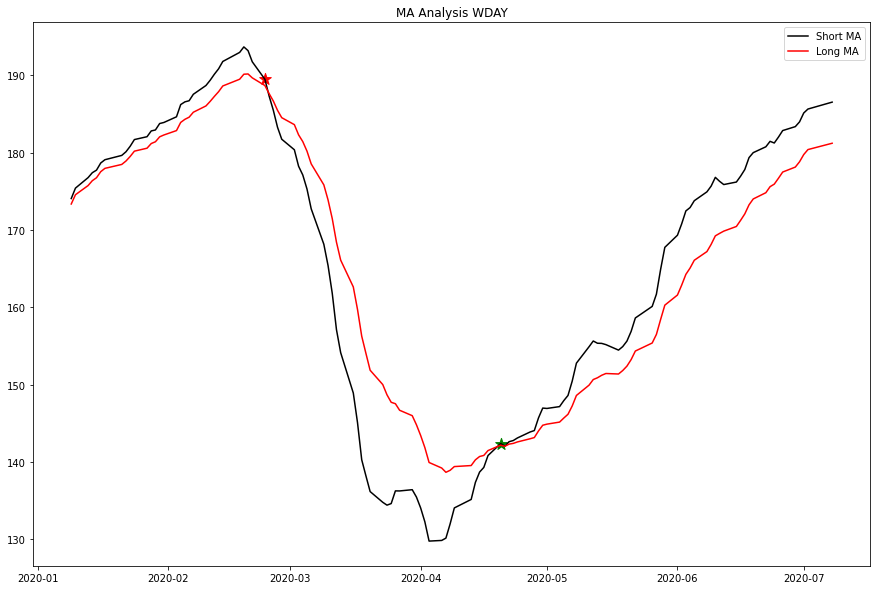

[*********************100%***********************]  1 of 1 completed


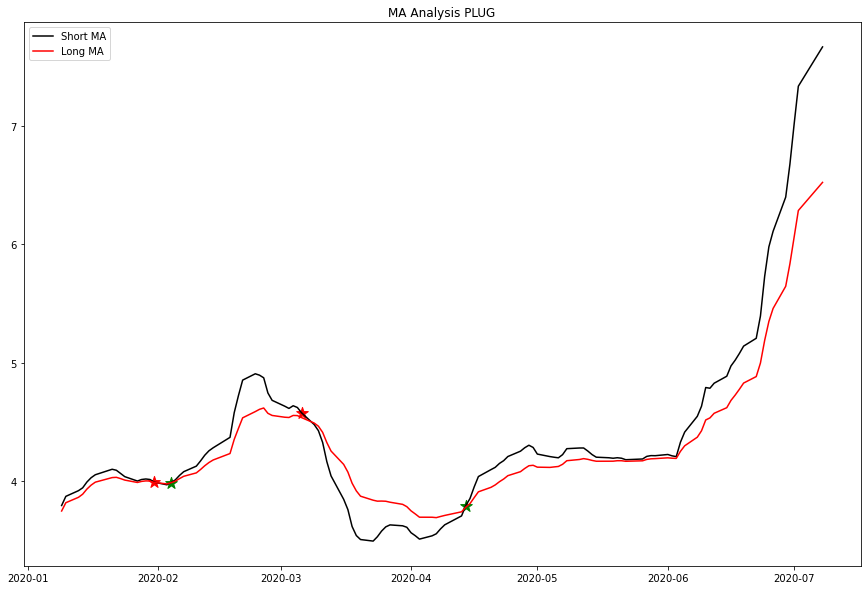

[*********************100%***********************]  1 of 1 completed


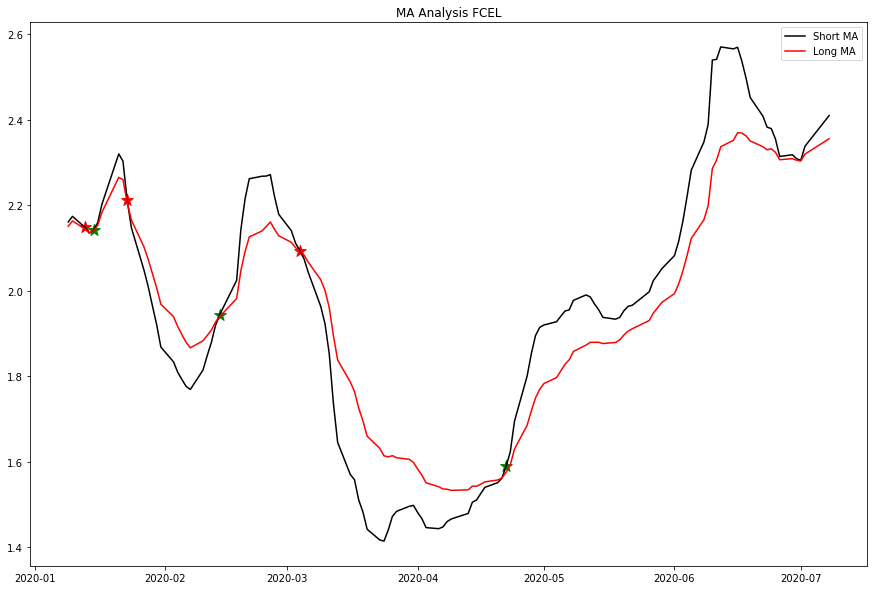

[*********************100%***********************]  1 of 1 completed


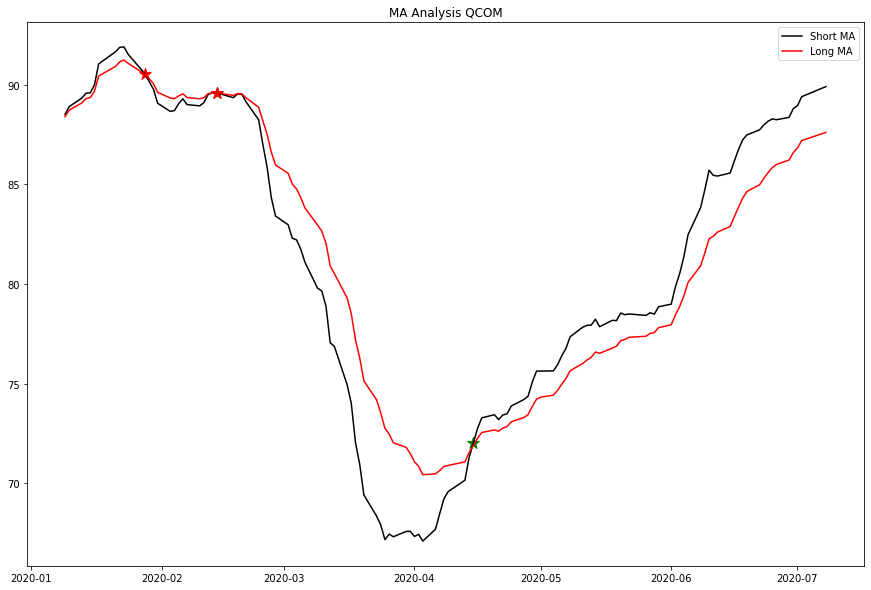

[*********************100%***********************]  1 of 1 completed


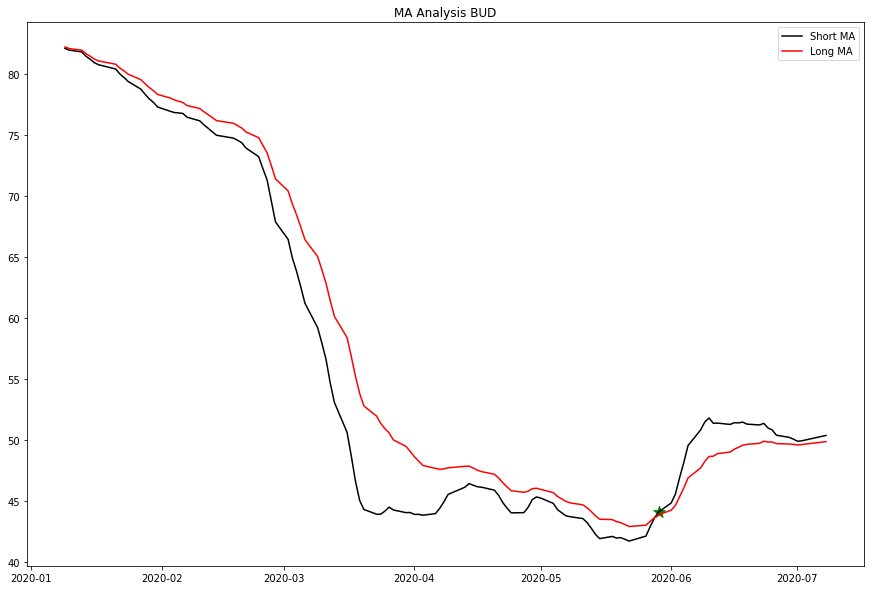

[*********************100%***********************]  1 of 1 completed


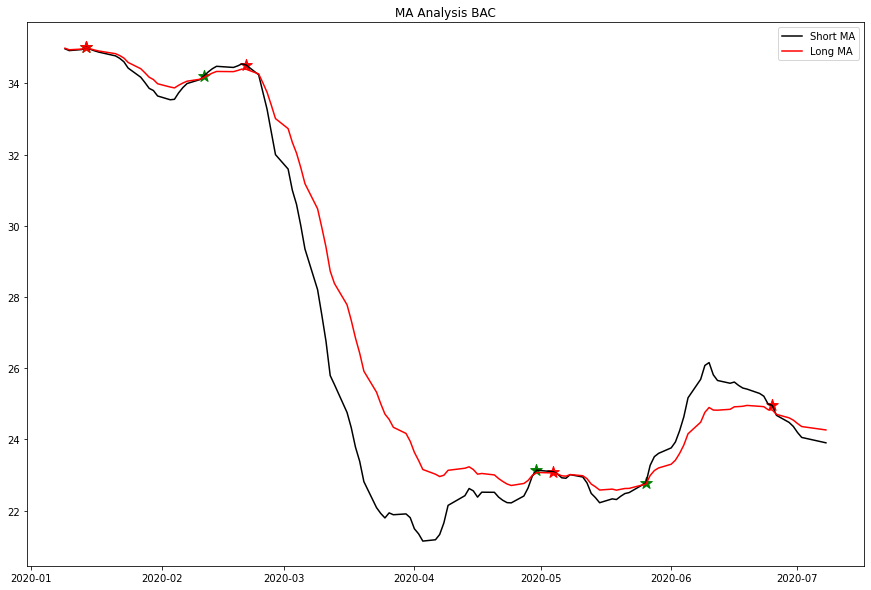

[*********************100%***********************]  1 of 1 completed


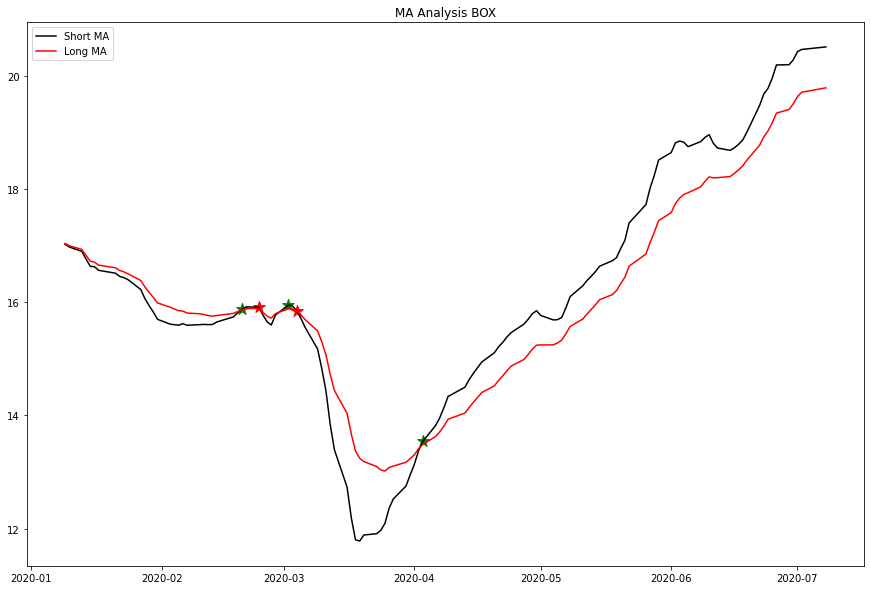

[*********************100%***********************]  1 of 1 completed


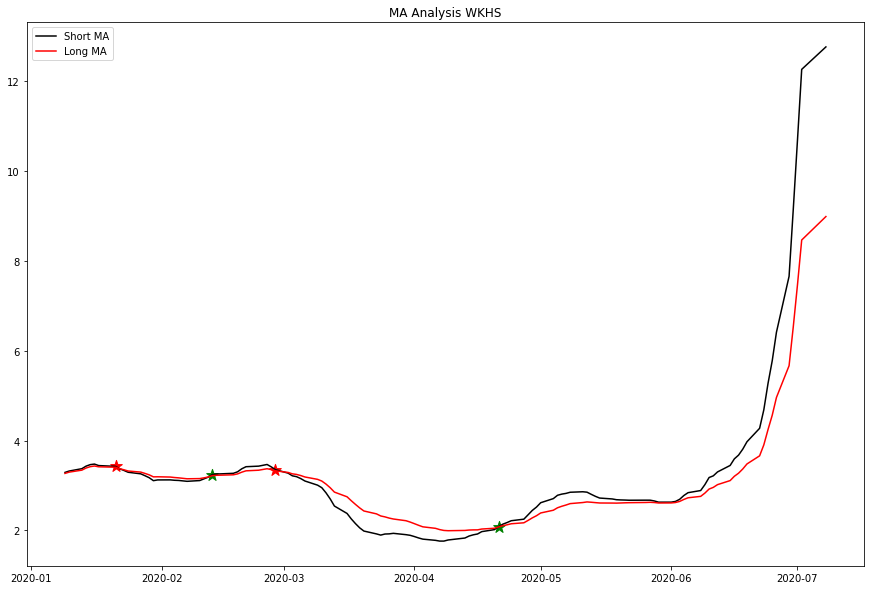

[*********************100%***********************]  1 of 1 completed


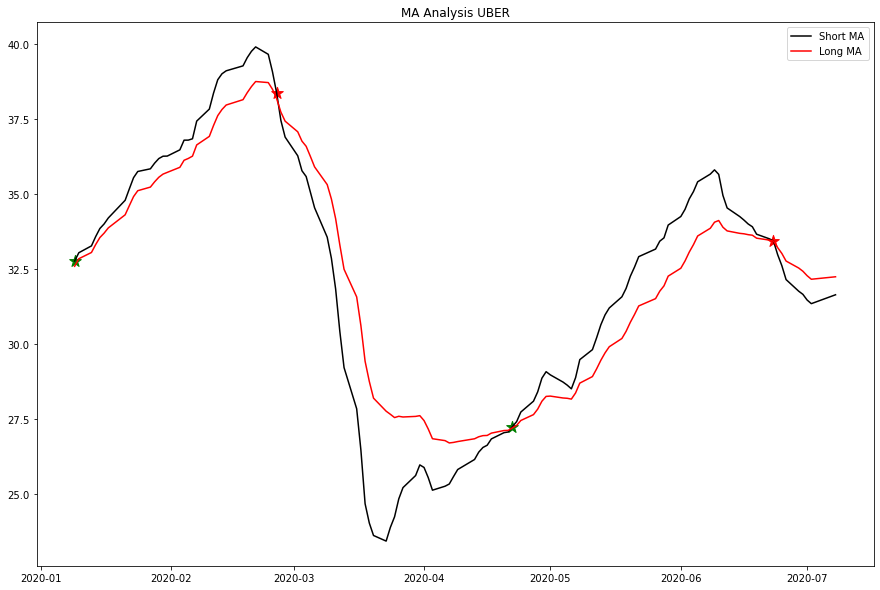

[*********************100%***********************]  1 of 1 completed


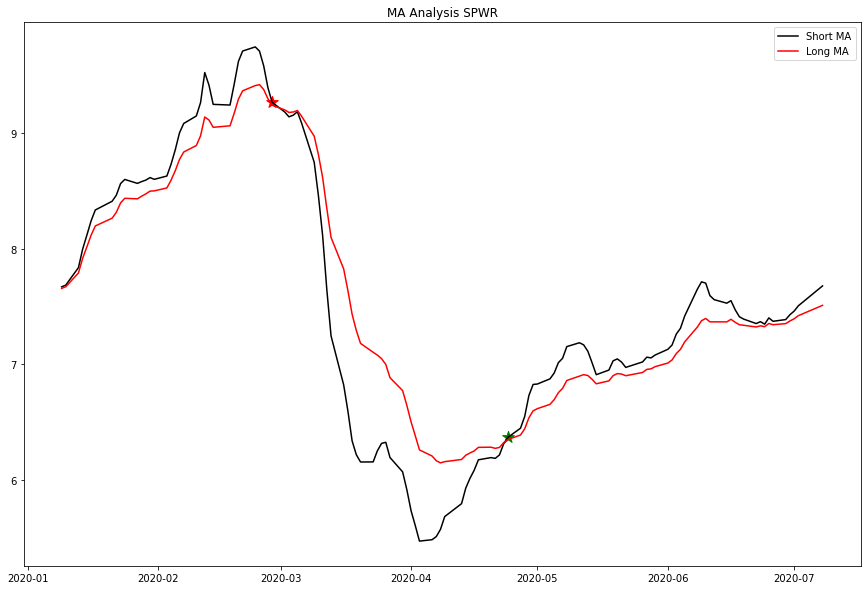

[*********************100%***********************]  1 of 1 completed


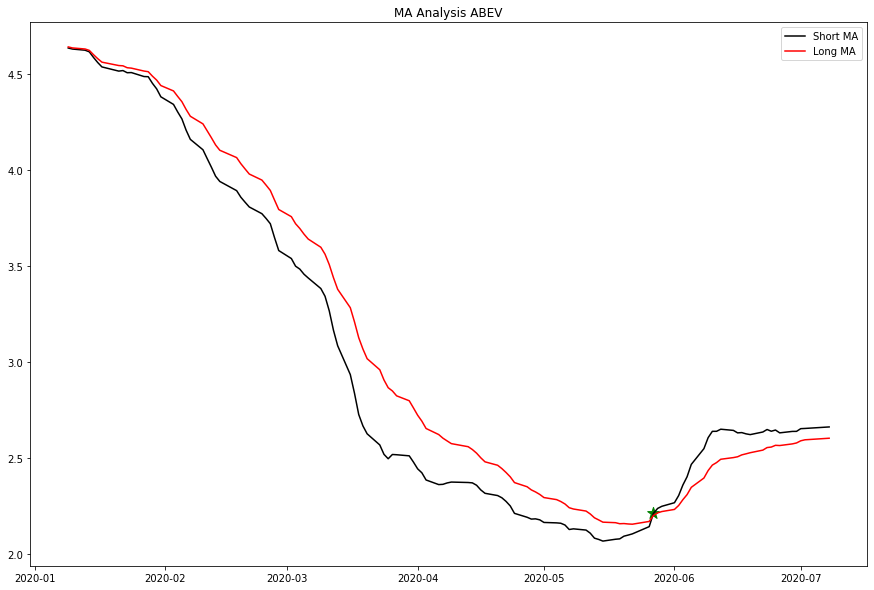

[*********************100%***********************]  1 of 1 completed


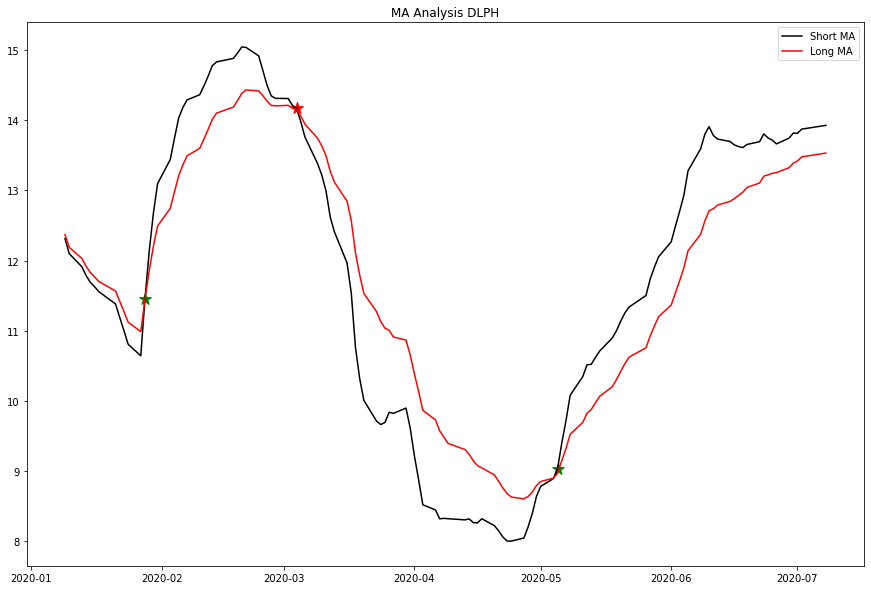

[*********************100%***********************]  1 of 1 completed


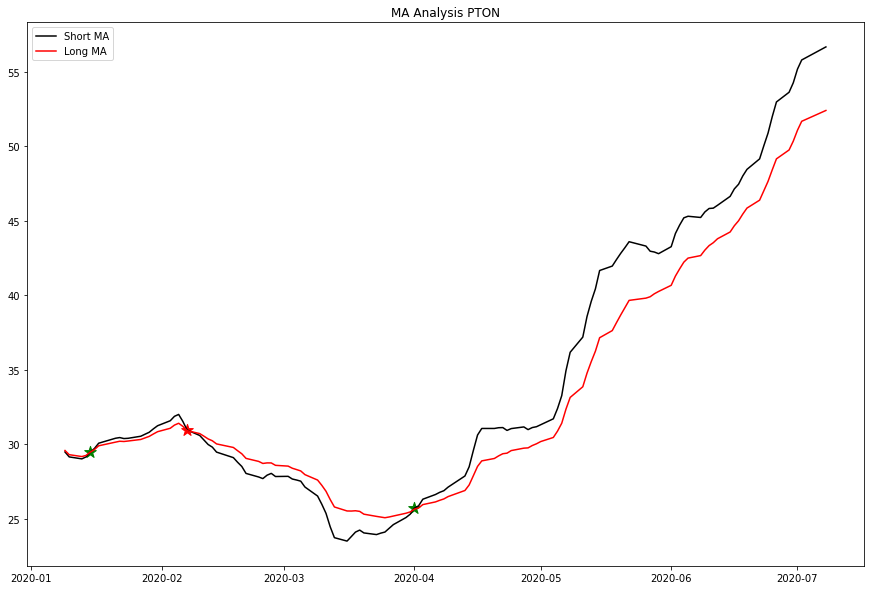

In [69]:

for ticker in ticks:
    
    start = '2020-01-01'
    SDOW = generate_stock_data(start,now,ticker)




    plt.figure(figsize=(15,10))
    plt.plot(SDOW['Date'],SDOW['12Day_Moving_Average_Close'],label='Short MA',color='k')
    plt.plot(SDOW['Date'],SDOW['26Day_Moving_Average_Close'],label='Long MA',color='r')


    for values in range(len(SDOW)):
        if values!=0:
            if SDOW['MACD'].iloc[values]<0:
                if SDOW['MACD'].iloc[values-1]>0:
                    plt.scatter(SDOW['Date'].iloc[values-1],SDOW['12Day_Moving_Average_Close'].iloc[values-1],marker='*',
                           color='red',s=150)

        if SDOW['MACD'].iloc[values]>=0:
            if SDOW['MACD'].iloc[values-1]<0:
                plt.scatter(SDOW['Date'].iloc[values],SDOW['12Day_Moving_Average_Close'].iloc[values],marker='*',
                           color='green',s=150)


    plt.title('MA Analysis {}'.format(ticker))

    plt.legend()
    plt.show()

#### red star siginal a downward trend & green stars signal an upward trend

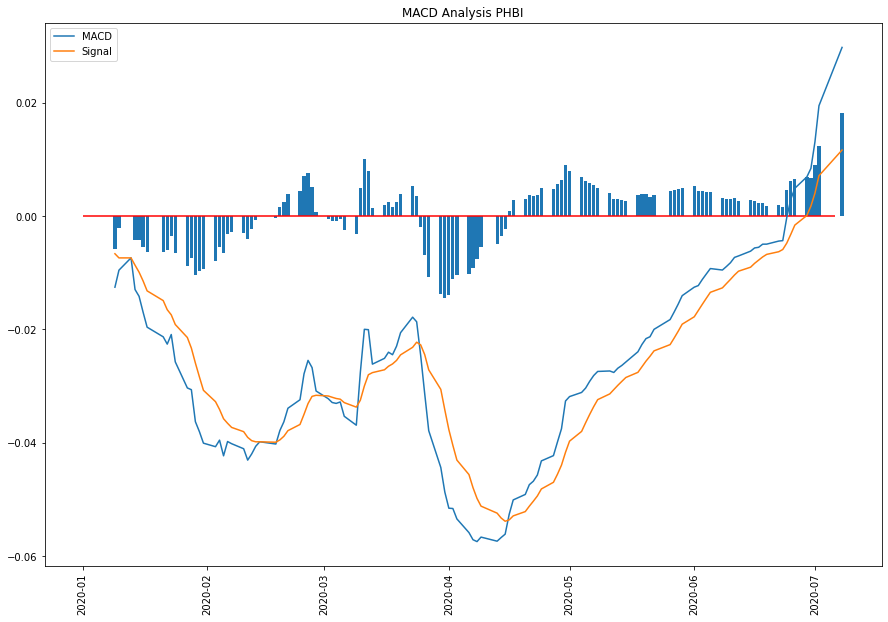

In [68]:
plt.figure(figsize=(15,10))
plt.title('MACD Analysis {}'.format(ticker))
plt.plot(SDOW['Date'],SDOW['MACD'],label='MACD')
plt.plot(SDOW['Date'],SDOW['signal'],label='Signal')
plt.hlines(0,start,now,'r')
plt.bar(SDOW['Date'],SDOW['hist'])
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [9]:
min_by_min = get_quote_data_by_minute(symbol="WORK",data_range='1d', data_interval='1m')
min_by_min.tail(20)

,Datetime,OPEN,HIGH,LOW,CLOSE,VOLUME
70,2020-07-06 14:41:00,31.205000,31.219999,31.184000,31.219999,24990.0
71,2020-07-06 14:42:00,31.215000,31.330000,31.215000,31.330000,131330.0
72,2020-07-06 14:43:00,31.325001,31.389999,31.309999,31.385900,42823.0
73,2020-07-06 14:44:00,31.389999,31.440001,31.385000,31.430000,0.0
74,2020-07-06 14:45:00,31.434999,31.495001,31.434999,31.485001,81339.0
75,2020-07-06 14:46:00,31.485001,31.555000,31.475000,31.540001,104752.0
76,2020-07-06 14:47:00,31.540001,31.540001,31.485001,31.520000,28610.0
77,2020-07-06 14:48:00,31.514999,31.540001,31.500000,31.530001,26914.0
78,2020-07-06 14:49:00,31.535000,31.549999,31.530001,31.530001,27522.0
79,2020-07-06 14:50:00,31.520000,31.540001,31.495001,31.502001,31386.0


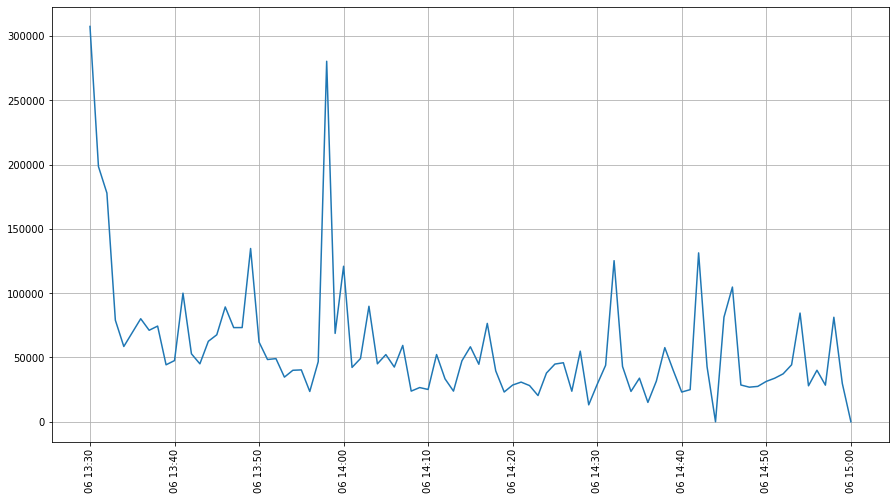

In [10]:
plt.figure(figsize=(15,8))

plt.plot(min_by_min['Datetime'],min_by_min['VOLUME'])


plt.xticks(rotation=90)
plt.grid(True)
plt.show()

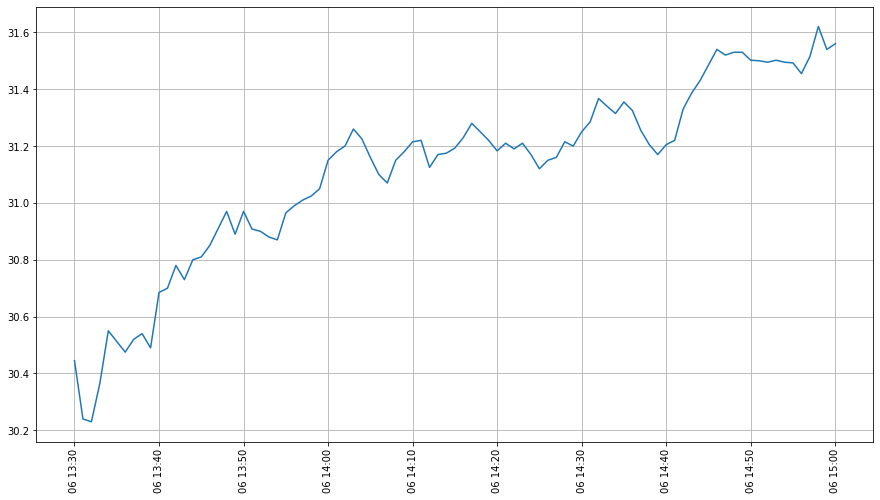

In [11]:
plt.figure(figsize=(15,8))

plt.plot(min_by_min['Datetime'],min_by_min['CLOSE'])


plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [ ]:
# For data manipulation
import pandas as pd

# To extract fundamental data
from bs4 import BeautifulSoup as bs
import requests

In [ ]:
import requests, re, json, pprint
import numpy as np
p = re.compile(r'root\.App\.main = (.*);')
tickers = ['PLUG','FCEL']
results = {}

with requests.Session() as s:

    for ticker in tickers:
        r = s.get('https://finance.yahoo.com/quote/{}/key-statistics?p={}'.format(ticker,ticker))
        data = json.loads(p.findall(r.text)[0])
        key_stats = data['context']['dispatcher']['stores']['QuoteSummaryStore']
        results.setdefault(ticker,[])
        results[ticker]
        try:
            res = {'EnterPrise Value' :key_stats['defaultKeyStatistics']['enterpriseValue']['fmt']}
            results[ticker].append(res)
        except:
            results[ticker].append({'EnterPrise Value':np.nan})
            
        try:
            res = {'Trailing P/E' : key_stats['summaryDetail']['trailingPE']['fmt']}
            results[ticker].append(res)
        except:
            results[ticker].append({'Trailing P/E':np.nan})
            
        try:
            res = {'Forward P/E' : key_stats['summaryDetail']['forwardPE']['fmt']}
            results[ticker].append(res)
        except:
            results[ticker].append({'Forward P/E':np.nan})
            
            
        try:
            res = {'PEG Ratio (5 yr expected)' : key_stats['defaultKeyStatistics']['pegRatio']['fmt']}
            results[ticker].append(res)
        except:
            results[ticker].append({'PEG Ratio (5 yr expected)':np.nan})
            
        try:
            res = {'Return on Assets' : key_stats['financialData']['returnOnAssets']['fmt']}
            results[ticker].append(res)
        except:
            results[ticker].append({"Return on Assets":np.nan})
            
        try:
            res = {'Quarterly Revenue Growth' : key_stats['financialData']['revenueGrowth']['fmt']}
            results[ticker].append(res)
        except:
            results[ticker].append({"Quarterly Revenue Growth":np.nan})
            
        res = {'Company' : ticker}
        results[ticker].append(res)    
            
        

In [ ]:
import requests, re, json, pprint
import numpy as np
p = re.compile(r'root\.App\.main = (.*);')
tickers = ['PLUG','FCEL']
q_results = {}
main_keys = ['trailingPsRatio', 
             'quarterlyPbRatio', 
             'quarterlyForwardPeRatio',
             'quarterlyMarketCap', 
             'quarterlyPeRatio', 
             'trailingMarketCap',
             'trailingEnterprisesValueEBITDARatio',
             'quarterlyEnterprisesValueEBITDARatio', 
             'trailingForwardPeRatio', 
             'trailingEnterpriseValue',
             'trailingPeRatio', 
             'quarterlyEnterprisesValueRevenueRatio', 
             'quarterlyPsRatio', 
             'trailingEnterprisesValueRevenueRatio', 
             'quarterlyPegRatio', 
             'trailingPbRatio',
             'quarterlyEnterpriseValue', 
             'trailingPegRatio', 
             'timestamp']

with requests.Session() as s:

    for ticker in tickers:
        r = s.get('https://finance.yahoo.com/quote/{}/key-statistics?p={}'.format(ticker,ticker))
        data = json.loads(p.findall(r.text)[0])
        
        key_stats = data['context']['dispatcher']['stores']['QuoteTimeSeriesStore']
        
        q_results.setdefault(ticker,[])
        for mk in main_keys:
            try:
                res = {mk: key_stats['timeSeries'][mk][1]['reportedValue']['raw']}
                
                q_results[ticker].append(res)
            except:
                q_results[ticker].append({mk:np.nan})
            
        res = {'Company' : ticker}
        q_results[ticker].append(res)  
            
                
                
                
        

In [ ]:
finstats = {}

for k in results.keys():
    c = results[k]
    for ix in range(len(c)):
        for key,val in  c[ix].items():
            finstats.setdefault(key,[])
            finstats[key].append(val)
    
            

In [ ]:
fstat = pd.DataFrame(finstats)

In [ ]:
finstats_q = {}

for k in q_results.keys():
    c = q_results[k]
    for ix in range(len(c)):
        for key,val in  c[ix].items():
            finstats_q.setdefault(key,[])
            finstats_q[key].append(val)
    

In [ ]:
fstatsq = pd.DataFrame(finstats_q)

In [ ]:
full_df = pd.merge(fstat,fstatsq,on='Company')
full_df_transpose=full_df.T
full_df_transpose.columns = list(full_df['Company'])

In [ ]:
full_df_transpose